In [ ]:
# before running this script, it is necessary to run fmriprep on the raw data
# https://fmriprep.org/en/stable/index.html
# example call:
#fmriprep ~/PROJECTS/fus/data/bold ~/PROJECTS/fus/data/fmriprep_out participant -w ~/PROJECTS/fus/data/fmriprep_working --fs-license-file ~/license.txt --mem 64000000000 --nprocs 10 --participant-label 02


In [1]:
import nilearn
from nilearn.image import resample_img
import nibabel as nib
from templateflow import api
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
## get functional data
path_to_data = "/Users/jacekdmochowski/PROJECTS/fus/data/fmriprep_out/sub-02/func"

pre_filename = "sub-02_task-pre_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
fus_filename = "sub-02_task-fus_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
post_filename = "sub-02_task-post_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"

In [3]:
pre_img = nib.load(os.path.join(path_to_data, pre_filename))
fus_img = nib.load(os.path.join(path_to_data, fus_filename))
post_img = nib.load(os.path.join(path_to_data, post_filename))

In [4]:
## get atlas
path = api.get('MNI152NLin2009cAsym', atlas="Schaefer2018", desc="1000Parcels17Networks", resolution=2, suffix="dseg", extension="nii.gz")
#path = api.get('MNI152NLin2009cAsym', atlas="HOSPA", desc="th25", resolution=2, suffix="dseg", extension="nii.gz")
#path= api.get('MNI152NLin2009cAsym', atlas="DiFuMo", desc="1024dimensions", resolution=2, suffix="probseg", extension="nii.gz")

atlas = nib.load(path)
target_affine = atlas.affine
target_shape = np.array(atlas.dataobj).shape

In [5]:
# for probabilistic atlases
#dseg = np.argmax(np.array(atlas.dataobj), axis=3)

In [6]:
# get the atlas labels
atlas_labels = np.unique(np.array(atlas.dataobj))
#atlas_labels = np.unique(dseg)

In [7]:
pre_img.shape, target_shape

((77, 95, 82, 300), (97, 115, 97))

In [8]:
resampled_pre_img = resample_img(pre_img, target_affine=target_affine, target_shape=target_shape[0:3])

In [9]:
resampled_fus_img = resample_img(fus_img, target_affine=target_affine, target_shape=target_shape[0:3])

In [10]:
resampled_post_img = resample_img(post_img, target_affine=target_affine, target_shape=target_shape[0:3])

In [11]:
atlas.shape, resampled_pre_img.shape, resampled_fus_img.shape, resampled_post_img.shape

((97, 115, 97), (97, 115, 97, 300), (97, 115, 97, 300), (97, 115, 97, 300))

In [12]:
rois = np.unique(np.array(atlas.get_fdata()))
#rois = np.unique(dseg)
rois

array([   0.,    1.,    2., ...,  998.,  999., 1000.])

In [13]:
mu_pwr_pre = np.zeros(len(rois))
mu_pwr_fus = np.zeros(len(rois))
mu_pwr_post = np.zeros(len(rois))

sigma_pre = np.zeros(len(rois))
sigma_fus = np.zeros(len(rois))
sigma_post = np.zeros(len(rois))

stim_onsets = [1,61,121,181,241]
epoch_len = 59
pre_epoch = np.zeros( ( len(stim_onsets), epoch_len, len(rois) ) )
fus_epoch = np.zeros( ( len(stim_onsets), epoch_len, len(rois) ) )
post_epoch = np.zeros( ( len(stim_onsets), epoch_len, len(rois) ) )

n_voxels_in_roi = np.zeros(len(rois))

for i, roi in enumerate(rois):

    print(i, roi)

    is_in_roi = nilearn.image.get_data(atlas)==roi

    atlased_resampled_pre_img = resampled_pre_img.get_fdata()[is_in_roi]
    atlased_resampled_fus_img = resampled_fus_img.get_fdata()[is_in_roi]
    atlased_resampled_post_img = resampled_post_img.get_fdata()[is_in_roi]

    mu_pwr_pre[i] = np.mean(atlased_resampled_pre_img)
    mu_pwr_fus[i] = np.mean(atlased_resampled_fus_img)
    mu_pwr_post[i] = np.mean(atlased_resampled_post_img)

    sigma_pre[i] = np.mean(np.std(atlased_resampled_pre_img, axis=1))
    sigma_fus[i] = np.mean(np.std(atlased_resampled_fus_img, axis=1))
    sigma_post[i] = np.mean(np.std(atlased_resampled_post_img, axis=1))

    for ii, onset in enumerate(stim_onsets):
        if int(onset)+epoch_len < atlased_resampled_pre_img.shape[1]:
            pre_epoch[ii,:, i] = np.mean(atlased_resampled_pre_img[:,int(onset):int(onset)+epoch_len], axis=0)
            fus_epoch[ii,:, i] = np.mean(atlased_resampled_fus_img[:,int(onset):int(onset)+epoch_len], axis=0)
            post_epoch[ii,:, i] = np.mean(atlased_resampled_post_img[:,int(onset):int(onset)+epoch_len], axis=0)
        else:
            # fill with nans
            pre_epoch[ii,:, i] = np.nan
            fus_epoch[ii,:, i] = np.nan
            post_epoch[ii,:, i] = np.nan

    n_voxels_in_roi[i] = np.sum(is_in_roi)

# nanmean across epochs
pre_epoch_mean = np.nanmean(pre_epoch, axis=0)
fus_epoch_mean = np.nanmean(fus_epoch, axis=0)
post_epoch_mean = np.nanmean(post_epoch, axis=0)

0 0.0
1 1.0
2 2.0
3 3.0
4 4.0
5 5.0
6 6.0
7 7.0
8 8.0
9 9.0
10 10.0
11 11.0
12 12.0
13 13.0
14 14.0
15 15.0
16 16.0
17 17.0
18 18.0
19 19.0
20 20.0
21 21.0
22 22.0
23 23.0
24 24.0
25 25.0
26 26.0
27 27.0
28 28.0
29 29.0
30 30.0
31 31.0
32 32.0
33 33.0
34 34.0
35 35.0
36 36.0
37 37.0
38 38.0
39 39.0
40 40.0
41 41.0
42 42.0
43 43.0
44 44.0
45 45.0
46 46.0
47 47.0
48 48.0
49 49.0
50 50.0
51 51.0
52 52.0
53 53.0
54 54.0
55 55.0
56 56.0
57 57.0
58 58.0
59 59.0
60 60.0
61 61.0
62 62.0
63 63.0
64 64.0
65 65.0
66 66.0
67 67.0
68 68.0
69 69.0
70 70.0
71 71.0
72 72.0
73 73.0
74 74.0
75 75.0
76 76.0
77 77.0
78 78.0
79 79.0
80 80.0
81 81.0
82 82.0
83 83.0
84 84.0
85 85.0
86 86.0
87 87.0
88 88.0
89 89.0
90 90.0
91 91.0
92 92.0
93 93.0
94 94.0
95 95.0
96 96.0
97 97.0
98 98.0
99 99.0
100 100.0
101 101.0
102 102.0
103 103.0
104 104.0
105 105.0
106 106.0
107 107.0
108 108.0
109 109.0
110 110.0
111 111.0
112 112.0
113 113.0
114 114.0
115 115.0
116 116.0
117 117.0
118 118.0
119 119.0
120 120.0
121 121.0


In [14]:
# make a dataframe with roi as the index and the mu_pwr_pre, mu_pwr_fus, mu_pwr_post as columns

df = pd.DataFrame(data={'pre':mu_pwr_pre, 'fus':mu_pwr_fus, 'post':mu_pwr_post, 'n_voxels':n_voxels_in_roi}, index=rois)

pct_change_acute = 100*(mu_pwr_fus-mu_pwr_pre)/mu_pwr_pre
pct_change_chronic = 100*(mu_pwr_post-mu_pwr_pre)/mu_pwr_pre

pct_change_std_acute = 100*(sigma_fus-sigma_pre)/sigma_pre
pct_change_std_chronic = 100*(sigma_post-sigma_pre)/sigma_pre

df['pct_change_acute'] = pct_change_acute
df['pct_change_chronic'] = pct_change_chronic
df['pct_change_std_acute'] = pct_change_std_acute
df['pct_change_std_chronic'] = pct_change_std_chronic

In [26]:
df.mean()

pre                       7676.064435
fus                       7670.416403
post                      7633.145152
n_voxels                  1080.954046
pct_change_acute             0.022104
pct_change_chronic          -0.415896
pct_change_std_acute        -0.584103
pct_change_std_chronic      -1.621533
dtype: float64

In [16]:
df.pct_change_std_chronic.le(0).mean()

0.6603396603396603

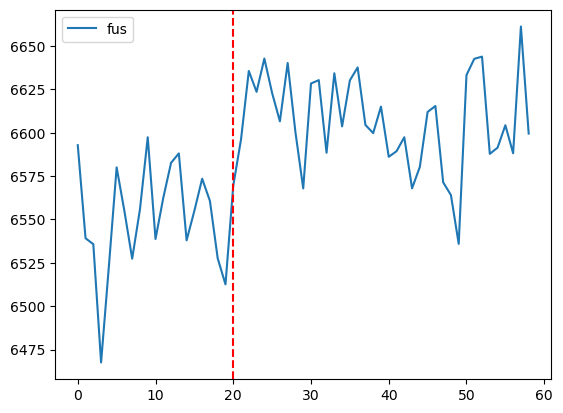

In [17]:
roi=134
# draw a vertical line at t=20
#plt.plot(pre_epoch_mean[:,roi], label='pre')
plt.plot(fus_epoch_mean[:,roi], label='fus')
#plt.plot(post_epoch_mean[:,roi], label='post')
plt.axvline(x=20, color='r', linestyle='--')
plt.legend()

In [18]:
'''
mu_roi_ts_pre = np.mean(atlased_resampled_pre_img, axis=0)
mu_roi_ts_fus = np.mean(atlased_resampled_fus_img, axis=0)
mu_roi_ts_post = np.mean(atlased_resampled_post_img, axis=0)

fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(mu_roi_ts_pre, label='pre')
ax.plot(mu_roi_ts_fus, label='fus')
ax.plot(mu_roi_ts_post, label='post')
plt.legend()
'''

"\nmu_roi_ts_pre = np.mean(atlased_resampled_pre_img, axis=0)\nmu_roi_ts_fus = np.mean(atlased_resampled_fus_img, axis=0)\nmu_roi_ts_post = np.mean(atlased_resampled_post_img, axis=0)\n\nfig, ax = plt.subplots(1,1,figsize=(10,5))\nax.plot(mu_roi_ts_pre, label='pre')\nax.plot(mu_roi_ts_fus, label='fus')\nax.plot(mu_roi_ts_post, label='post')\nplt.legend()\n"

In [19]:
df.loc[df["pct_change_std_acute"].argmin()]

pre                       7190.396447
fus                       6962.071890
post                      6885.274871
n_voxels                   236.000000
pct_change_acute            -3.175410
pct_change_chronic          -4.243460
pct_change_std_acute       -37.317084
pct_change_std_chronic     -31.401821
Name: 619.0, dtype: float64

In [20]:
df.mean()

pre                       7676.064435
fus                       7670.416403
post                      7633.145152
n_voxels                  1080.954046
pct_change_acute             0.022104
pct_change_chronic          -0.415896
pct_change_std_acute        -0.584103
pct_change_std_chronic      -1.621533
dtype: float64

In [21]:
atlased_resampled_pre_img.shape

(76, 300)

In [22]:
"""
roi = 134
is_in_roi = nilearn.image.get_data(atlas)==roi
atlased_resampled_pre_img = resampled_pre_img.get_fdata()[is_in_roi ]
atlased_resampled_fus_img = resampled_fus_img.get_fdata()[is_in_roi ]
atlased_resampled_post_img = resampled_post_img.get_fdata()[is_in_roi ]

# plot voxel average time series before during and after
#plt.plot(np.mean(atlased_resampled_pre_img, axis=0), label='pre')
#plt.plot(np.mean(atlased_resampled_fus_img, axis=0), label='fus')
#plt.plot(np.mean(atlased_resampled_post_img, axis=0), label='post')
#plt.xlim([120, 180])
"""



"\nroi = 134\nis_in_roi = nilearn.image.get_data(atlas)==roi\natlased_resampled_pre_img = resampled_pre_img.get_fdata()[is_in_roi ]\natlased_resampled_fus_img = resampled_fus_img.get_fdata()[is_in_roi ]\natlased_resampled_post_img = resampled_post_img.get_fdata()[is_in_roi ]\n\n# plot voxel average time series before during and after\n#plt.plot(np.mean(atlased_resampled_pre_img, axis=0), label='pre')\n#plt.plot(np.mean(atlased_resampled_fus_img, axis=0), label='fus')\n#plt.plot(np.mean(atlased_resampled_post_img, axis=0), label='post')\n#plt.xlim([120, 180])\n"

In [23]:
from nilearn import plotting

uid = 'MNI152NLin2009cAsym'
nii = nib.load(api.get(uid, resolution=2, desc=None, suffix='T1w'))
atlas_nii = nib.load(api.get(
    uid, resolution=2,
    desc="1000Parcels17Networks",
    atlas="Schaefer2018",
    suffix='dseg'
))

In [24]:
atlas_nii

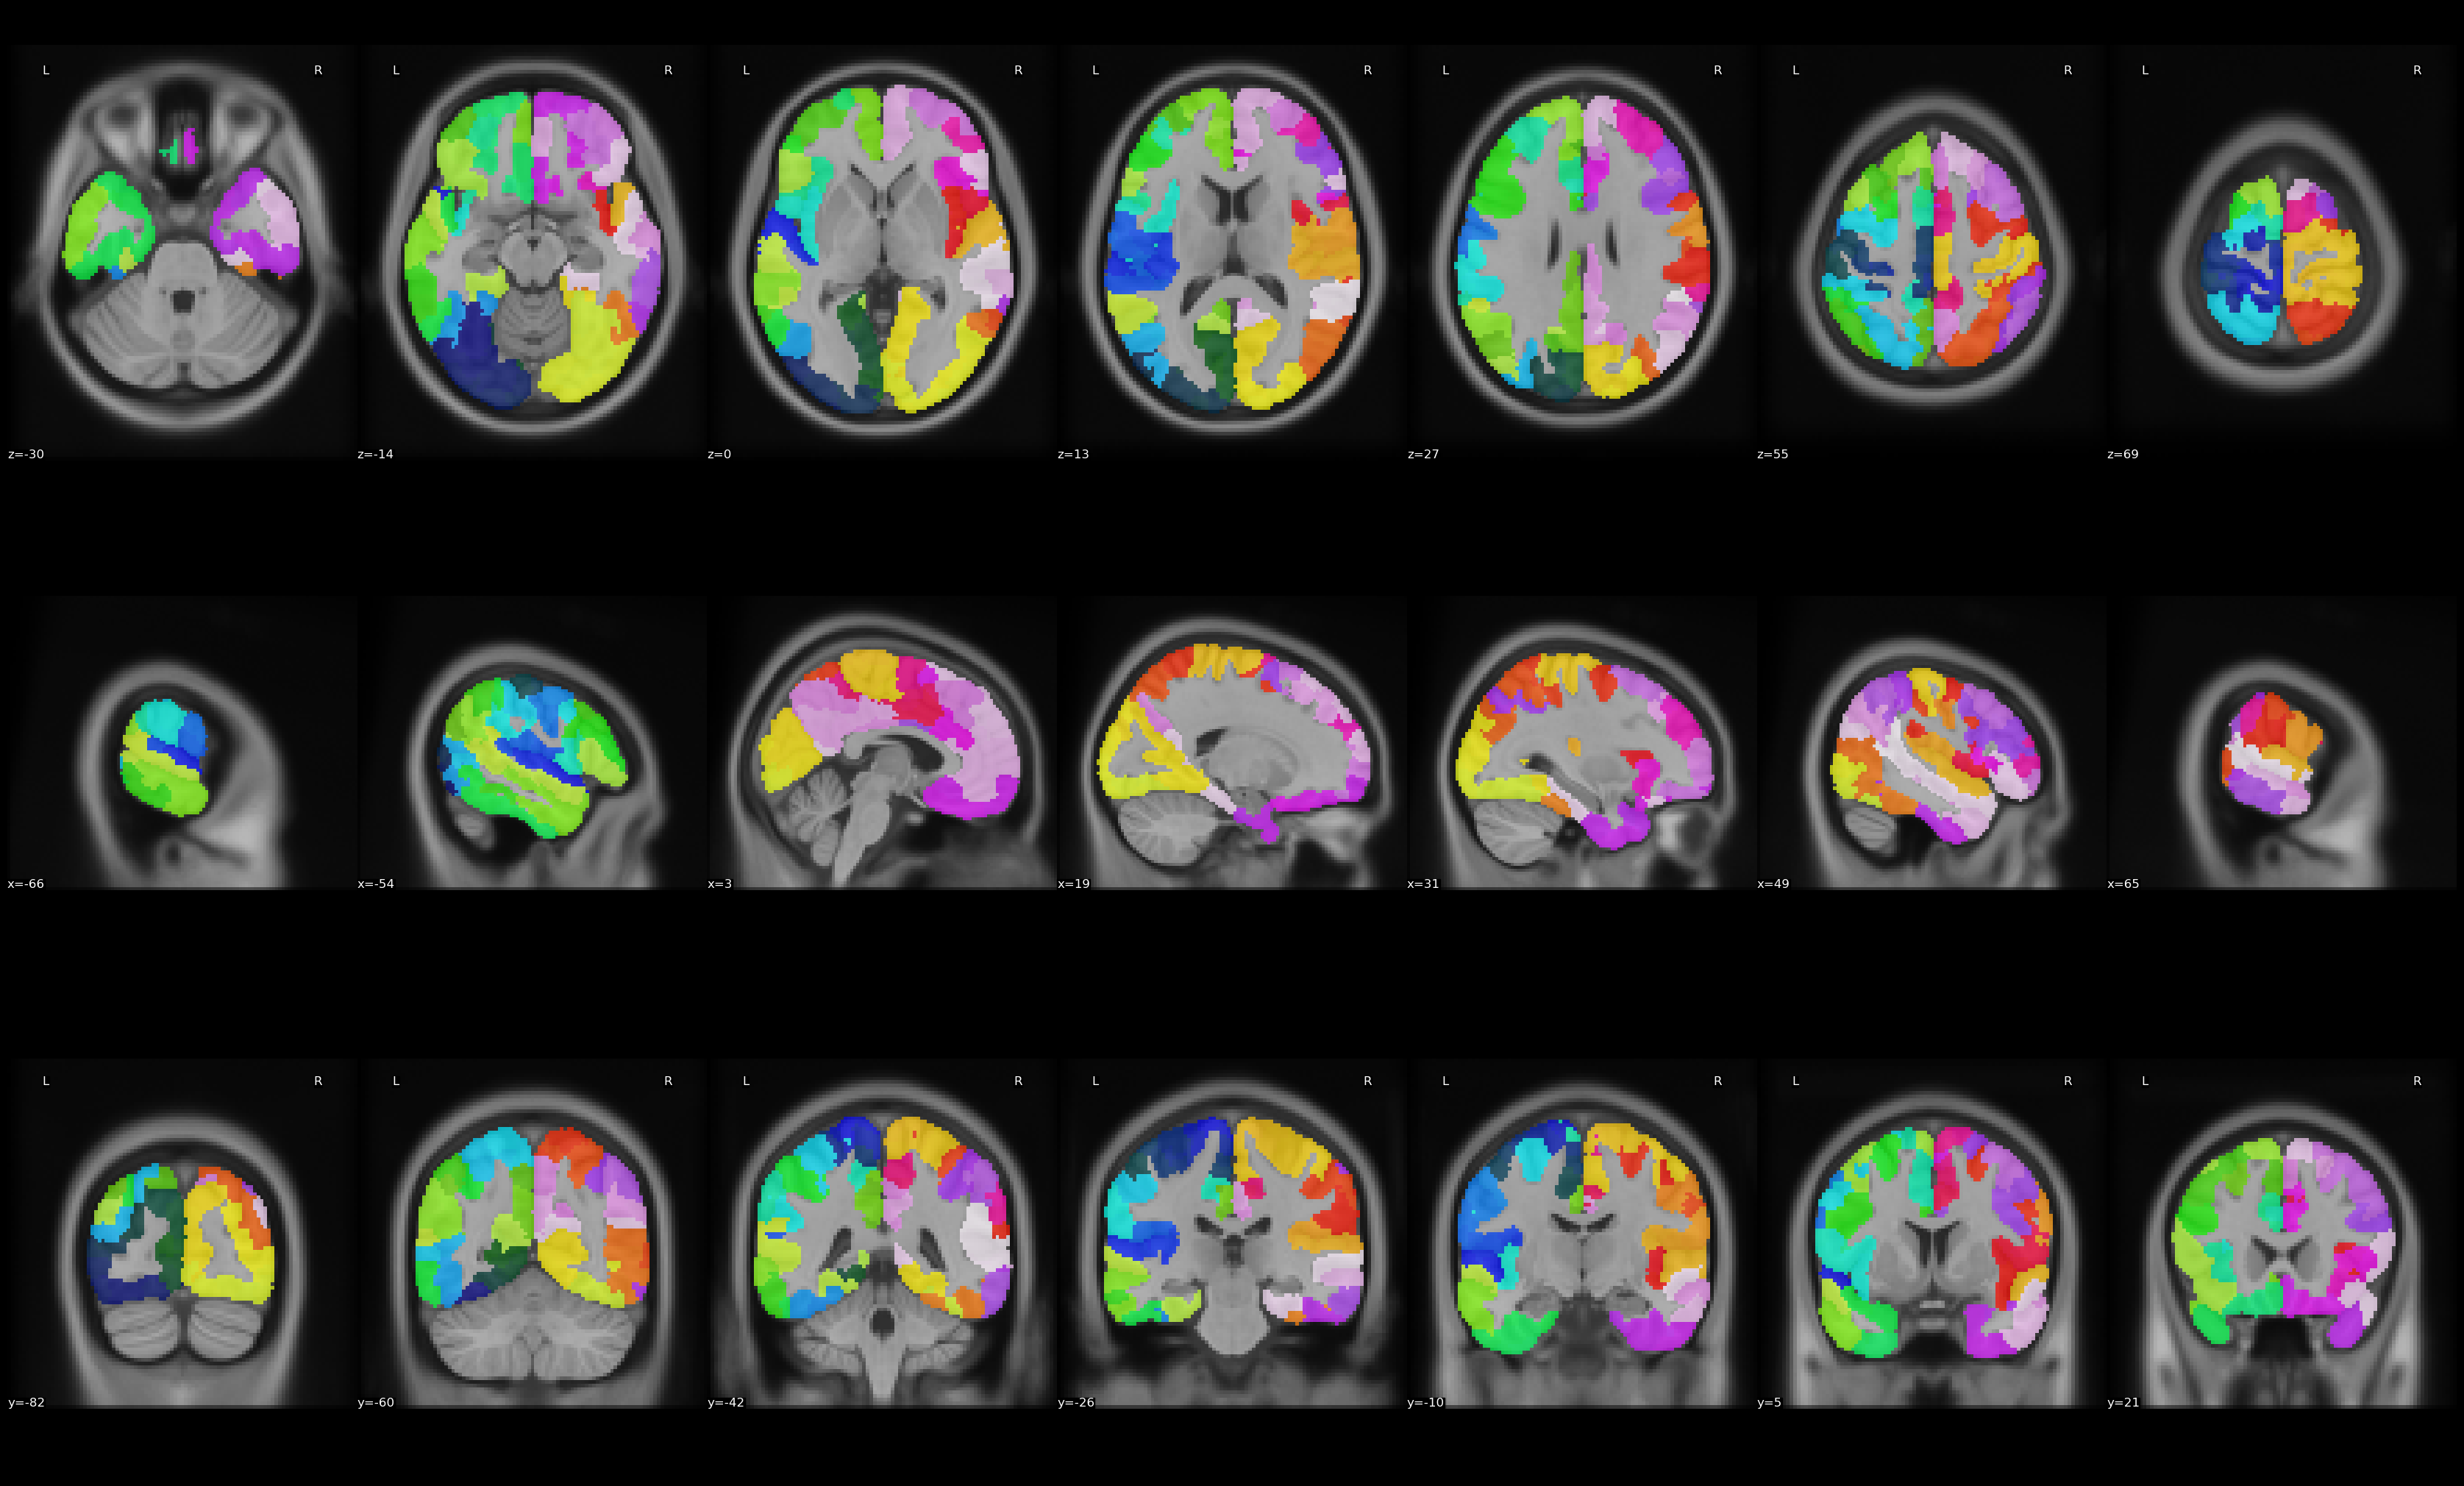

In [25]:
plotting.plot_roi(roi_img=atlas_nii, bg_img=nii, display_mode='mosaic')